# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow==2.10  pandas matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [5]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

# 1. Preprocess

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000 # number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 1195s 171ms/step - loss: 0.0645 - val_loss: 0.0481
Epoch 2/10
6981/6981 [==============================] - 1134s 162ms/step - loss: 0.0461 - val_loss: 0.0399
Epoch 3/10
6981/6981 [==============================] - 1118s 160ms/step - loss: 0.0414 - val_loss: 0.0384
Epoch 4/10
6981/6981 [==============================] - 1120s 160ms/step - loss: 0.0375 - val_loss: 0.0346
Epoch 5/10
6981/6981 [==============================] - 1117s 160ms/step - loss: 0.0338 - val_loss: 0.0301
Epoch 6/10
6981/6981 [==============================] - 1121s 161ms/step - loss: 0.0303 - val_loss: 0.0277
Epoch 7/10
6981/6981 [==============================] - 1117s 160ms/step - loss: 0.0274 - val_loss: 0.0240
Epoch 8/10
6981/6981 [==============================] - 1099s 157ms/step - loss: 0.0249 - val_loss: 0.0216
Epoch 9/10
6981/6981 [==============================] - 1098s 157ms/step - loss: 0.0223 - val_loss: 0.0183
Epoch 10/10
6981/6981 [==============

In [20]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

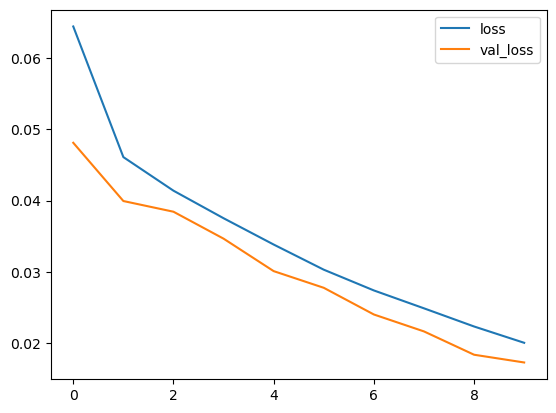

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [22]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [23]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 1s 511ms/step


In [24]:
(res > 0.5).astype(int)

array([[1, 1, 1, 0, 1, 0]])

In [25]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [26]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 118ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [27]:
res.shape

(1, 6)

# 4. Evaluate Model

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [29]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [30]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 79ms/step


In [31]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9166423678398132, Recall:0.9241845607757568, Accuracy:0.5356068015098572


# 5. Test and Gradio

In [32]:
!pip install gradio==3.43.1 jinja2

Defaulting to user installation because normal site-packages is not writeable


In [33]:
import tensorflow as tf
import gradio as gr

In [34]:
model.save('toxicity.h5')

In [35]:
model = tf.keras.models.load_model('toxicity.h5')

In [36]:
input_str = vectorizer('hey i freaken hate you!')

In [37]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 536ms/step


In [38]:
res

array([[0.8766222 , 0.0041904 , 0.02752962, 0.01403853, 0.35405824,
        0.0204451 ]], dtype=float32)

In [39]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [40]:
interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),outputs='text')

C:\Users\RAMPAGE\AppData\Local\Temp\ipykernel_6900\4227781947.py:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),outputs='text')
C:\Users\RAMPAGE\AppData\Local\Temp\ipykernel_6900\4227781947.py:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),outputs='text')
C:\Users\RAMPAGE\AppData\Local\Temp\ipykernel_6900\4227781947.py:1: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),outputs='text')


In [44]:
df[df['severe_toxic'] == 1]['comment_text'].iloc[4]

'What a motherfucking piece of crap those fuckheads for blocking us!'

1/1 [==============================] - 0s 167ms/step


In [42]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.43.1, however version 4.29.0 is available, please upgrade.
--------
Running on public URL: https://ca036b67a7df39a06d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 174ms/step
